In [ ]:
import os
import random
random.seed(0)
!unzip './dataset/pneumothoraxdataset.zip'

In [ ]:
%tensorflow_version 1.x
import shutil
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply


from keras import optimizers
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
import glob
train = glob.glob('/../train/*')
mask = glob.glob('/../masks/*')
test = glob.glob('/../test/*')

(12047, 12047, 3205)

In [ ]:
all_mask_fn = glob.glob('/../masks/*')
mask_df = pd.DataFrame()
mask_df['file_names'] = all_mask_fn
mask_df['mask_percentage'] = 0
mask_df.set_index('file_names',inplace=True)
for fn in all_mask_fn:
    mask_df.loc[fn,'mask_percentage'] = np.array(Image.open(fn)).sum()/(256*256*255) #255 is bcz img range is 255
    
mask_df.reset_index(inplace=True)
mask_df['labels'] = 0
mask_df.loc[mask_df.mask_percentage>0,'labels'] = 1
#sns.distplot(mask_df.mask_percentage.values)

In [ ]:
all_train_fn = glob.glob('/../train/*')
total_samples = len(all_train_fn)
idx = np.arange(total_samples)
train_fn,val_fn = train_test_split(all_train_fn,stratify=mask_df.labels,test_size=0.1,random_state=10)

print('No. of train files:', len(train_fn))
print('No. of val files:', len(val_fn))

masks_train_fn = [fn.replace('/train/','/masks/') for fn in train_fn]    
masks_val_fn = [fn.replace('/train/','/masks/') for fn in val_fn]

No. of train files: 10842
No. of val files: 1205


In [ ]:
!mkdir '/../im_train'
train_dir = '/../im_train'
for full_fn in train_fn:
    fn = full_fn.split('/')[-1]
    shutil.move(full_fn,os.path.join(train_dir,fn))
    
!mkdir '/../mask_train'
train_dir = '/content/mask_train'
for full_fn in masks_train_fn:
    fn = full_fn.split('/')[-1]
    shutil.move(full_fn,os.path.join(train_dir,fn))
    
!mkdir '/../im_val'
train_dir = '/../im_val'
for full_fn in val_fn:
    fn = full_fn.split('/')[-1]
    shutil.move(full_fn,os.path.join(train_dir,fn))
    
!mkdir '/../mask_val'
train_dir = '/../mask_val'
for full_fn in masks_val_fn:
    fn = full_fn.split('/')[-1]
    shutil.move(full_fn,os.path.join(train_dir,fn))

In [ ]:
train_im, train_mask = '/../im_train','mask_train'
val_im,   val_mask   = '/../im_val','/../mask_val'

h, w, batch_size = 256, 256, 16

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, train_im_path=train_im,train_mask_path=train_mask,
                 augmentations=None, batch_size=batch_size,img_size=256, n_channels=3, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.train_im_paths = glob.glob(train_im_path+'/*')
        
        self.train_im_path = train_im_path
        self.train_mask_path = train_mask_path

        self.img_size = img_size
        
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augmentations
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.train_im_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.train_im_paths))]

        # Find list of IDs
        list_IDs_im = [self.train_im_paths[k] for k in indexes]

        # Generate data
        X, y = self.data_generation(list_IDs_im)

        if self.augment is None:
            return X,np.array(y)/255
        else:            
            im,mask = [],[]   
            for x,y in zip(X,y):
                augmented = self.augment(image=x, mask=y)
                im.append(augmented['image'])
                mask.append(augmented['mask'])
            return np.array(im),np.array(mask)/255

    def on_epoch_end(self):
          'Updates indexes after each epoch'
          self.indexes = np.arange(len(self.train_im_paths))
          if self.shuffle == True:
              np.random.shuffle(self.indexes)

    def data_generation(self, list_IDs_im):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((len(list_IDs_im),self.img_size,self.img_size, self.n_channels))
        y = np.empty((len(list_IDs_im),self.img_size,self.img_size, 1))

        # Generate data
        for i, im_path in enumerate(list_IDs_im):
            
            im = np.array(Image.open(im_path))
            mask_path = im_path.replace(self.train_im_path,self.train_mask_path)
            
            mask = np.array(Image.open(mask_path))
            
            
            if len(im.shape)==2:
                im = np.repeat(im[...,None],3,2)

            # Resize sample
            X[i,] = cv2.resize(im,(self.img_size,self.img_size))

            # Store class
            y[i,] = cv2.resize(mask,(self.img_size,self.img_size))[..., np.newaxis]
            y[y>0] = 255

        return np.uint8(X),np.uint8(y)

In [ ]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
        RandomContrast(),
        RandomGamma(),
        RandomBrightness(),
    OneOf([
        ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(),
        OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    RandomSizedCrop(min_max_height=(176, 256), height=h, width=w,p=0.25),
    ToFloat(max_value=1)
],p=1)


AUGMENTATIONS_TEST = Compose([
    ToFloat(max_value=1)
],p=1)

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

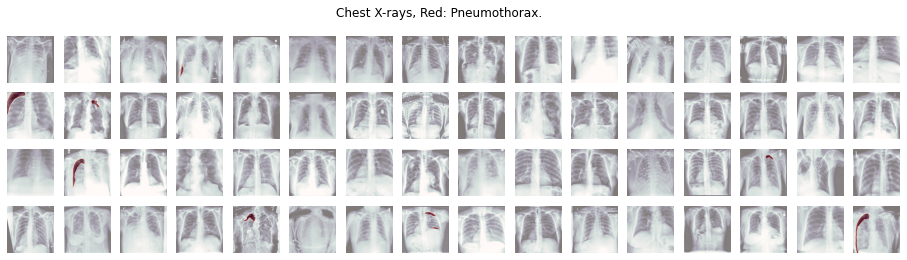

In [ ]:
a = DataGenerator(batch_size=64,augmentations=AUGMENTATIONS_TRAIN,shuffle=False)
images,masks = a.__getitem__(0)
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i,(im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[:,:,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

In [ ]:
def get_iou_vector(A, B):
    # Numpy version
    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.compat.v1.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [ ]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [ ]:
from efficientnet import EfficientNetB4

def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.1):

    backbone = EfficientNetB4(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)
    input = backbone.input
    start_neurons = 8

    conv4 = backbone.layers[342].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
#     uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)  #conv1_2
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = backbone.layers[154].output
    uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
#     uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = backbone.layers[92].output
    uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
#     uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[30].output
    uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
#     uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
#     uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [ ]:
tf.keras.backend.clear_session()
img_size = 256
model = UEfficientNet(input_shape=(img_size,img_size,3),dropout_rate=0.3)
model.summary()

Model: "u-xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 128, 128, 48) 0           batch_normalization_1[0][0]      
_________________________________________________________________________________________

In [ ]:
model.compile(loss=bce_dice_loss, optimizer='adam', metrics=[my_iou_metric])

Model With Entire DataSet (Without Sampling)


In [ ]:
epochs = 15

batch_size = 32
#swa = SWA('/content/keras_swa.model',67)
valid_im_path,valid_mask_path = '/content/im_val','/content/mask_val'
# Generators
training_generator = DataGenerator(augmentations=AUGMENTATIONS_TRAIN,img_size=img_size)
validation_generator = DataGenerator(train_im_path = valid_im_path ,
                                     train_mask_path=valid_mask_path,augmentations=AUGMENTATIONS_TEST,
                                     img_size=img_size)

history = model.fit_generator(generator=training_generator,
                            validation_data=validation_generator,                            
                            use_multiprocessing=False,
                            epochs=epochs,verbose=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in greater


Epoch 1/15
 - 1121s - loss: 1.0596 - my_iou_metric: 1.1984e-04 - val_loss: 1.0851 - val_my_iou_metric: 0.1714
Epoch 2/15
 - 1073s - loss: 0.8798 - my_iou_metric: 0.0139 - val_loss: 1.0158 - val_my_iou_metric: 0.4832
Epoch 3/15
 - 1072s - loss: 0.7809 - my_iou_metric: 0.3612 - val_loss: 0.8861 - val_my_iou_metric: 0.7062
Epoch 4/15
 - 1078s - loss: 0.7376 - my_iou_metric: 0.5418 - val_loss: 1.0264 - val_my_iou_metric: 0.7274
Epoch 5/15
 - 1077s - loss: 0.7253 - my_iou_metric: 0.5606 - val_loss: 0.9983 - val_my_iou_metric: 0.7566
Epoch 6/15
 - 1074s - loss: 0.7045 - my_iou_metric: 0.5875 - val_loss: 0.8540 - val_my_iou_metric: 0.6570
Epoch 7/15
 - 1074s - loss: 0.6845 - my_iou_metric: 0.6118 - val_loss: 0.8658 - val_my_iou_metric: 0.7106
Epoch 8/15
 - 1078s - loss: 0.6809 - my_iou_metric: 0.6121 - val_loss: 0.3808 - val_my_iou_metric: 0.7483
Epoch 9/15
 - 1082s - loss: 0.6678 - my_iou_metric: 0.6113 - val_loss: 0.4876 - val_my_iou_metric: 0.7155
Epoch 10/15
 - 1076s - loss: 0.6721 - my_i

In [ ]:
valid_im_path,valid_mask_path = '/content/im_val','/content/mask_val'
# Generators
training_generator = DataGenerator(augmentations=AUGMENTATIONS_TRAIN,img_size=img_size)
validation_generator = DataGenerator(train_im_path = valid_im_path ,
                                     train_mask_path=valid_mask_path,augmentations=AUGMENTATIONS_TEST,
                                     img_size=img_size)


history2 = model.fit_generator(generator=training_generator,
                            validation_data=validation_generator,                            
                            use_multiprocessing=False,
                            epochs=25,verbose=2)

Epoch 1/25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in greater


 - 376s - loss: 0.6251 - my_iou_metric: 0.6871 - val_loss: 1.0134 - val_my_iou_metric: 0.7256
Epoch 2/25
 - 353s - loss: 0.6355 - my_iou_metric: 0.6816 - val_loss: 0.5291 - val_my_iou_metric: 0.7284
Epoch 3/25
 - 353s - loss: 0.6274 - my_iou_metric: 0.6774 - val_loss: 0.3164 - val_my_iou_metric: 0.7417
Epoch 4/25
 - 353s - loss: 0.6229 - my_iou_metric: 0.6888 - val_loss: 0.3517 - val_my_iou_metric: 0.7523
Epoch 5/25
 - 353s - loss: 0.6198 - my_iou_metric: 0.6818 - val_loss: 0.4568 - val_my_iou_metric: 0.7628
Epoch 6/25
 - 353s - loss: 0.6007 - my_iou_metric: 0.6941 - val_loss: 0.8369 - val_my_iou_metric: 0.7571
Epoch 7/25
 - 353s - loss: 0.6115 - my_iou_metric: 0.7024 - val_loss: 0.5320 - val_my_iou_metric: 0.7262
Epoch 8/25
 - 353s - loss: 0.6126 - my_iou_metric: 0.6912 - val_loss: 0.5061 - val_my_iou_metric: 0.7752
Epoch 9/25
 - 353s - loss: 0.6100 - my_iou_metric: 0.7029 - val_loss: 0.5446 - val_my_iou_metric: 0.6627
Epoch 10/25
 - 353s - loss: 0.6164 - my_iou_metric: 0.7106 - val_l

In [ ]:
with open('/content/drive/My Drive/Case-Study 1/history/All Data/history1', 'rb') as file_pi:
  history1 = pickle.load(file_pi)

with open('/content/drive/My Drive/Case-Study 1/history/All Data/history2', 'rb') as file_pi:
  history2 = pickle.load(file_pi)

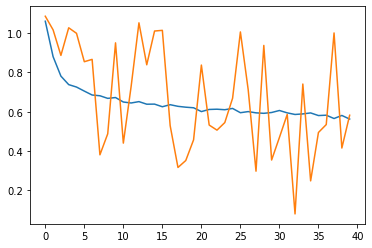

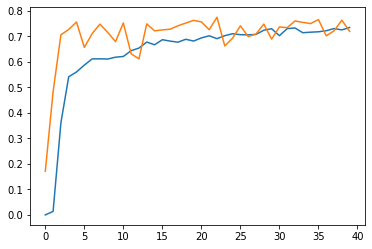

In [ ]:
plt.plot(history1['loss']+history2['loss'])
plt.plot(history1['val_loss']+history2['val_loss'])
plt.show()
plt.plot(history1['my_iou_metric']+history2['my_iou_metric'])
plt.plot(history1['val_my_iou_metric']+history2['val_my_iou_metric'])
plt.show()

## Inference Model


In [ ]:
model.load_weights('./models/segmentation.hdf5')

In [ ]:
class Inference:
  def __init__(self, root_dir, model):
    self.root_dir = root_dir
    self.model = model

  def Predict(self, img_id):
    path = self.root_dir+os.listdir(self.root_dir)[img_id]
    img = cv2.imread(path)
    p=model.predict(tf.expand_dims(img, axis=0), steps=1)
    mask = cv2.imread('/content/mask_val/'+os.listdir('/content/mask_val')[img_id])[:,:,0]
    pred = p.squeeze(axis=0)[:,:,0]
    return img, mask, pred

Green ==> Groundtruth, Red ==> Prediction


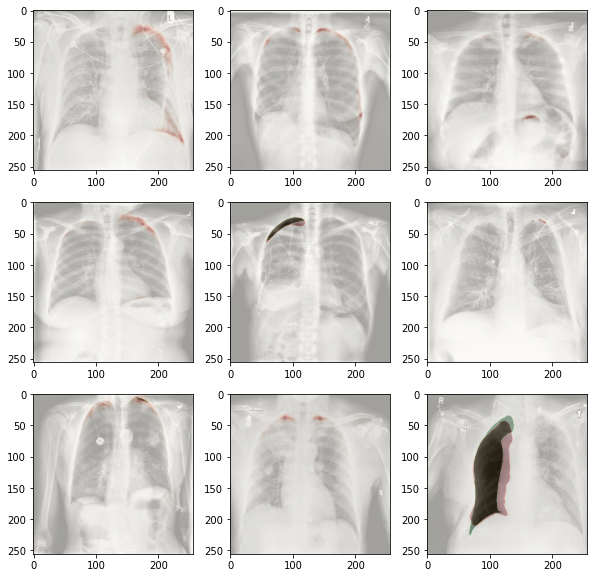

In [ ]:
print("Green ==> Groundtruth, Red ==> Prediction")

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

inference = Inference('/content/im_val/', model)

for i in range(3):
  for j in range(3):
    id = np.random.randint(100)
    img, mask, pred = inference.Predict(id)
    axs[i,j].imshow(img)
    axs[i,j].imshow(mask, cmap='Greens', alpha=0.5)
    axs[i,j].imshow(pred, alpha=0.3, cmap='Reds')
plt.show()

Green ==> Groundtruth, Red ==> Prediction


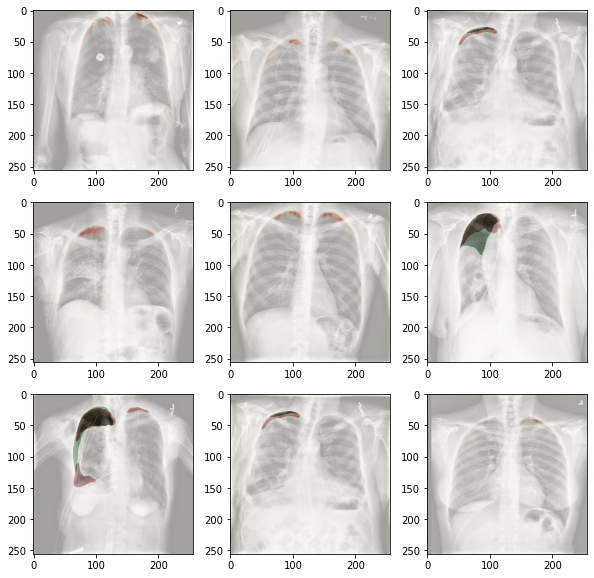

In [ ]:
print("Green ==> Groundtruth, Red ==> Prediction")

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

inference = Inference('/content/im_val/', model)

for i in range(3):
  for j in range(3):
    id = np.random.randint(50)
    img, mask, pred = inference.Predict(id)
    axs[i,j].imshow(img)
    axs[i,j].imshow(mask, cmap='Greens', alpha=0.5)
    axs[i,j].imshow(pred, alpha=0.3, cmap='Reds')
plt.show()